In [1]:
# Practice Skills: Random forest and gradient boosting

# Goal: It is your job to predict the sales price for each house (SalePrice)

# Metric: Submissions are evaluated on RMSE between the logarithm of the 
## predicted value and the logarithm of the observed sales price.

# Submission format.

# Study guides:
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# https://www.kaggle.com/mgmarques/houses-prices-complete-solution
# https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6
# https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5
    
# Dummy variables:
# https://www.youtube.com/watch?v=9yl6-HEY7_s
# https://www.youtube.com/watch?v=0s_1IsROgDc

# Categorical data:
# https://www.datacamp.com/community/tutorials/categorical-data

# Missing values:
# https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
# https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

# 1) Preparing the environment and uploading the data:

In [2]:
# Importing the libraries:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import seaborn as sns
import statsmodels.api as sm
from scipy import stats 
import sklearn.cross_validation as cv
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelBinarizer # separate variable into binary categories
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999 #To visualize the whole grid of columns

C:\Users\rafae\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Importing datasets:
train = pd.read_csv(r"C:\Users\rafae\Desktop\Code\Machine Learning\Kaggle - House Prices/train.csv")
print("Train data (rows, columns): " + str(train.shape))
df_train = pd.DataFrame(train)
# df_train_target = pd.DataFrame(data=train, columns=["SalePrice"])

test = pd.read_csv(r"C:\Users\rafae\Desktop\Code\Machine Learning\Kaggle - House Prices/test.csv")
print("Test data (rows, columns): " + str(test.shape))
df_test = pd.DataFrame(test)

# Dropping columns with missing, useless or repeated data:
### df_train.drop(columns=df_train["Utilities"], inplace=True)
### df_test.drop(columns=df_test["Utilities"], inplace=True)

Train data (rows, columns): (1460, 81)
Test data (rows, columns): (1459, 80)


# 2.1) Exploratory data analysis (general):

In [4]:
# A first look at the data:
# https://www.kaggle.com/mgmarques/houses-prices-complete-solution

def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'skewness', 'kurtosis', corr_col ]
        
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

pd.set_option('display.max_rows', 90)
details = rstr(df_train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1460, 81)
___________________________
Data types:
 object     43
int64      35
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,skewness,kurtosis,corr SalePrice
SalePrice,int64,1460,663,0,0.000000,1.882876,6.536282,1.000000
OverallQual,int64,1460,10,0,0.000000,0.216944,0.096293,0.790982
GrLivArea,int64,1460,861,0,0.000000,1.366560,4.895121,0.708624
GarageCars,int64,1460,5,0,0.000000,-0.342549,0.220998,0.640409
GarageArea,int64,1460,441,0,0.000000,0.179981,0.917067,0.623431
TotalBsmtSF,int64,1460,721,0,0.000000,1.524255,13.250483,0.613581
1stFlrSF,int64,1460,753,0,0.000000,1.376757,5.745841,0.605852
FullBath,int64,1460,4,0,0.000000,0.036562,-0.857043,0.560664
TotRmsAbvGrd,int64,1460,12,0,0.000000,0.676341,0.880762,0.533723
YearBuilt,int64,1460,112,0,0.000000,-0.613461,-0.439552,0.522897


In [5]:
# Statistical analysis of the numerical data:

display(df_train.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [6]:
# Data visualization:

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
# Printing all the columns from the origianl dataframe:

df_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
# Checking for duplicates in the data:

# idsUnique = len(set(df_train.Id))
# idsTotal = df_train.shape[0]
# idsDupli = idsTotal - idsUnique
# print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

In [9]:
# Code for checking the results of the droppage of missing values:

# df_train.drop(columns=[""])[:3]

In [10]:
# Code for changing a variable datatype:

# df_train[['MSZoning']] = df_train[['MSZoning']].astype(object)
# df_train[['MSZoning']].dtypes

In [11]:
# Code for finding numeric values:

# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# newdf = df_train.select_dtypes(include=numerics)
# newdf.columns

In [12]:
# Code for finding object values:

# objects = ['object']
# newdf2 = df_train.select_dtypes(include=objects)
# newdf2.columns

In [13]:
# Analysis of Outliers: Interquartile range (IQR):
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

# Q1 = df_train.quantile(0.25)
# Q3 = df_train.quantile(0.75)
# IQR = Q3 - Q1
# print(IQR)

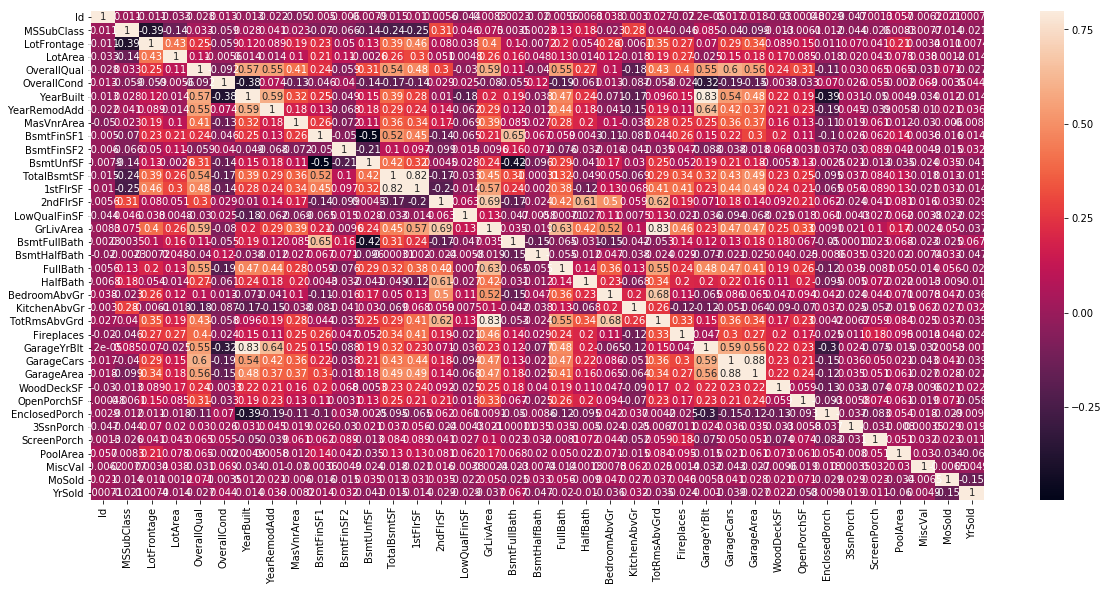

In [14]:
# Correlation Matrix:

numeric_features = df_train.select_dtypes(include=[np.number])

numeric_features.drop("SalePrice", axis = 1, inplace = True)
corr = numeric_features.corr()

f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 10}, annot=True);

# 2.2) Exploratory data analysis (specific):

# Id:

In [4]:
# "Id": 
# It must be deleted.

# Saving the 'Id' column:
# df_train_ID = df_train['Id']
# df_test_ID = df_test['Id']

df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

### Ok. Useless feature for the test. Drop.

# MsSubClass:

In [5]:
# "MSSubClass": 
# The building class.
# It is a category besides being numeric.
# Correlation: -0.084284

# sns.boxplot(x="MSSubClass", y="SalePrice", data=df_train, palette="pastel")

# print(df_train['MSSubClass'].value_counts())

df_train = pd.get_dummies(df_train, columns=["MSSubClass"])
df_test = pd.get_dummies(df_test, columns=["MSSubClass"])

### Ok. Many different categorical values with many incidences. Create dummies.

# MSZoning:

In [6]:
# 'MSZoning': 5 types of categories.
# The general zoning classification.
# It has no specific order.

# sns.boxplot(x="MSZoning", y="SalePrice", data=df_train, palette="pastel")

# df_train['MSZoning'].value_counts() # RL = 1151 values.

df_train = pd.get_dummies(df_train, columns=["MSZoning"])
df_test = pd.get_dummies(df_test, columns=["MSZoning"])

### Ok. Is there any column that should be dropped for being an outlier or insignificant?

# LotFrontage:

In [7]:
# "LotFrontage": 111 types of numbers.
# Linear feet of street connected to property.
# Correlation: 0.351799

# sns.jointplot(x="LotFrontage", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

df_train["LotFrontage"].fillna(0, inplace=True) # Size to 0 or average?
df_test["LotFrontage"].fillna(0, inplace=True) # Size to 0 or average?

### Ok. Delete outliers?

# LotArea:

In [8]:
# "LotArea": 1073 types of numbers.
# Correlation: 0.263843

# sns.jointplot(x="LotArea", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

### Ok. Positive correlation to SalePrice. 4 Outliers removed.

# Street:

In [9]:
# 'Street': 2 types of categories.
# Mostly redundant, as most streets are basically "Pave". Only 5 are "Grvl".

# df_train = pd.get_dummies(df_train, columns=["Street"]).head()
# sns.jointplot(x="Street", y="SalePrice", data=df_train, height=5, ratio=3)

df_train.drop("Street", axis = 1, inplace = True)
df_test.drop("Street", axis = 1, inplace = True)

### Ok. Drop for being irrelevant.

# Alley:

In [10]:
# 'Alley': 3 types of categories.
# Type of alley access.

# sns.boxplot(x="Alley", y="SalePrice", data=df_train, palette="pastel")

# df_train["Alley"].value_counts() # No = 1369.

# df_train["Alley"].fillna("No", inplace=True)
# df_test["Alley"].fillna("No", inplace=True)

df_train.drop(columns="Alley", axis = 1, inplace = True)
df_test.drop(columns="Alley", axis = 1, inplace = True)

### Ok. Mostly useless data. Drop.

# LotShape:

In [11]:
# 'LotShape': 4 types of categories.
# General shape of property

# result = df_train.groupby(["LotShape"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="LotShape", y="SalePrice", kind="box", data=df_train, order=result["LotShape"]);

# df_train['LotShape'].value_counts()

df_train = pd.get_dummies(df_train, columns=["LotShape"])
df_test = pd.get_dummies(df_test, columns=["LotShape"])

### Ok. It has a linear relationship with SalePrice. Dummy.

# LandContour:

In [12]:
# 'LandContour': 4 types of categories.
# Flatness of the property

# sns.catplot(x="LandContour", y="SalePrice", kind="box", data=df_train);

# df_train["LandContour"].value_counts()

df_train = pd.get_dummies(df_train, columns=["LandContour"])
df_test = pd.get_dummies(df_test, columns=["LandContour"])

### Ok. Categorical with no order. Dummy.

# Utilities:

In [13]:
# 'Utilities': 2 types of categories.

# sns.catplot(x="Utilities", y="SalePrice", kind="box", data=df_train);

# df_train['Utilities'].value_counts()

df_train.drop(['Utilities'], axis = 1, inplace=True)
df_test.drop(['Utilities'], axis = 1, inplace=True)

# Ok. All the same. Drop.

# LotConfig:

In [14]:
# 'LotConfig': 5 types of categories.
# Lot configuration.

# sns.catplot(x="LotConfig", y="SalePrice", kind="box", data=df_train);

# df_train["LotConfig"].value_counts()

df_train = df_train.replace({"LotConfig" : {"FR2" : "FR_Sum", "FR3" : "FR_Sum"}})
df_test = df_test.replace({"LotConfig" : {"FR2" : "FR_Sum", "FR3" : "FR_Sum"}})

df_train = pd.get_dummies(df_train, columns=["LotConfig"])
df_test = pd.get_dummies(df_test, columns=["LotConfig"])

### Ok. Categorical without order. Cluster FR2 and FR3. Dummy.

# LandSlope:

In [15]:
# 'LandSlope': 3 types of categories.
# Slope of property.

# sns.catplot(x="LandSlope", y="SalePrice", data=df_train);

# df_train["LandSlope"].value_counts() # Gtl: 1382 numbers.

df_train = df_train.replace({"LandSlope" : {"Mod" : "ModSev", "Sev" : "ModSev"}})
df_test = df_test.replace({"LandSlope" : {"Mod" : "ModSev", "Sev" : "ModSev"}})

df_train = pd.get_dummies(df_train, columns=["LandSlope"])
df_test = pd.get_dummies(df_test, columns=["LandSlope"])

### Ok. Cluster Mod and Sev. Dummy.

# Neighborhood:

In [16]:
# 'Neighborhood': 25 types of categories.
# Physical locations within Ames city limits.

# Graph:
# result = df_train.groupby(["Neighborhood"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# plt.figure(figsize=(8,6))
# sns.stripplot(x = df_train.Neighborhood, y = df_train.SalePrice,
#               order=result["Neighborhood"],jitter=0.1, alpha=0.5)
# plt.xticks(rotation=45)

# df_train["Neighborhood"].value_counts()

df_train = pd.get_dummies(df_train, columns=["Neighborhood"])
df_test = pd.get_dummies(df_test, columns=["Neighborhood"])

### Ok. Some neighborhoods are more expensive than others.

# Condition1:

In [17]:
# 'Condition1': 9 types of categories.
# Proximity to various conditions.

# result = df_train.groupby(["Condition1"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Condition1", y="SalePrice", kind="box", data=df_train, order=result["Condition1"]);

# df_train["Condition1"].value_counts() # Norm = 1260.

df_train = df_train.replace({"Condition1" : {"Feedr" : "Other", "Artery" : "Other",
                                            "RRAn" : "Other", "PosN" : "Other", 
                                            "RRAe" : "Other", "PosA" : "Other",
                                            "RRNn" : "Other", "RRNe" : "Other"}
                     })

df_test = df_test.replace({"Condition1" : {"Feedr" : "Other", "Artery" : "Other",
                                            "RRAn" : "Other", "PosN" : "Other", 
                                            "RRAe" : "Other", "PosA" : "Other",
                                            "RRNn" : "Other", "RRNe" : "Other"}
                     })

df_train = pd.get_dummies(df_train, columns=["Condition1"])
df_test = pd.get_dummies(df_test, columns=["Condition1"])

# df_train.head(3)

### Ok. Most values are Norm, and the rest of the values remain in a similar band.
### So, create a cluster for the rest, and create dummies for both.

# Condition2:

In [18]:
# 'Condition2': 8 types of categories.
# Proximity to various conditions.

# result = df_train.groupby(["Condition2"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Condition2", y="SalePrice", kind="box", data=df_train, order=result["Condition2"]);

# df_train["Condition2"].value_counts() # Norm = 1445.

df_train.drop(columns="Condition2", axis = 1, inplace=True)
df_test.drop(columns="Condition2", axis = 1, inplace=True)

### Ok. 1445 values are Norm. Drop.

# BldgType:

In [19]:
# 'BldgType': 5 types of categories.
# Type of dwelling.

# sns.catplot(x="BldgType", y="SalePrice", kind="box", data=df_train);

# df_train["BldgType"].value_counts()

df_train = pd.get_dummies(df_train, columns=["BldgType"])
df_test = pd.get_dummies(df_test, columns=["BldgType"])

### Ok. Categorical without order. Dummy.

# HouseStyle:

In [20]:
# 'HouseStyle': 8 types of categories.
# Style of dwelling.

# sns.catplot(x="HouseStyle", y="SalePrice", kind="box", data=df_train);

# df_train["HouseStyle"].value_counts()

df_train = pd.get_dummies(df_train, columns=["HouseStyle"])
df_test = pd.get_dummies(df_test, columns=["HouseStyle"])

### Ok. Many categories with fewer values. Cluster? How? Dummy.

# OverallQual:

In [21]:
# 'OverallQual': 10 types of numbers.
# Rates the overall material and finish of the house.
# Correlation: 0.790982

# sns.jointplot(x="OverallQual", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="OverallQual", y="SalePrice", data=df_train, palette="pastel")

### Ok. Strongly correlated with SalePrice. Ordinal. Maintain it as it is.

# OverallCond:

In [22]:
# 'OverallCond': 9 types of numbers.
# Rates the overall condition of the house.
# Correlation: -0.077856

# result = df_train.groupby(["OverallCond"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="OverallCond", y="SalePrice", kind="box", data=df_train, order=result["OverallCond"]);

# df_train["OverallCond"].value_counts()

### ??? Ordinal feature, but it is not properly organized. Should I reorganize it in
### the proper order? ???

# YearBuilt:

In [23]:
# "YearBuilt": 112 types of categories/numbers (dates).
# Original construction date.
# Correlation: 0.522897

# sns.catplot(x="YearBuilt", y="SalePrice", kind="box", data=df_train);

### Ok. The newer or the older the house, the higher the correlation to SalesPrice.
### Maintain it as it is. ???

# YearRemodAdd:

In [24]:
# "YearRemodAdd": 61 types of categories/numbers (dates).
# Remodel date (same as construction date if no remodeling or additions).
# Correlation: 0.507101

# sns.catplot(x="YearRemodAdd", y="SalePrice", kind="box", data=df_train);

### Ok. The newer the remodelling of a house, the higher the correlation to 
### SalesPrice. Maintain it as it is.

# RoofStyle:

In [25]:
# "RoofStyle": 6 types of categories.
# Type of roof.

# sns.catplot(x="RoofStyle", y="SalePrice", kind="box", data=df_train);

# df_train["RoofStyle"].value_counts()

df_train = pd.get_dummies(df_train, columns=["RoofStyle"])
df_test = pd.get_dummies(df_test, columns=["RoofStyle"])

### Ok. Categorical without order. Dummies.

# RoofMatl:

In [26]:
# "RoofMatl": 8 types of categories.
# Roof material.

# sns.catplot(x="RoofMatl", y="SalePrice", kind="box", data=df_train);

# df_train["RoofMatl"].value_counts() # CompShg: 1434 values.

df_train = pd.get_dummies(df_train, columns=["RoofMatl"])
df_test = pd.get_dummies(df_test, columns=["RoofMatl"])

### ??? Most features have almost no observations. Drop? ???

# Exterior1st:

In [27]:
# "Exterior1st": 15 types of categories. 
# Exterior covering on house.

# sns.catplot(x="Exterior1st", y="SalePrice", kind="box", data=df_train);

# df_train["Exterior1st"].value_counts()

df_train = pd.get_dummies(df_train, columns=["Exterior1st"])
df_test = pd.get_dummies(df_test, columns=["Exterior1st"])

### Ok. Dummy.

# Exterior2nd:

In [28]:
# "Exterior2nd": 16 types of categories.
# Exterior covering on house.

# sns.catplot(x="Exterior2nd", y="SalePrice", kind="box", data=df_train);

# df_train["Exterior2nd"].value_counts()

df_train.drop(columns="Exterior2nd", axis = 1, inplace=True)
df_test.drop(columns="Exterior2nd", axis = 1, inplace=True)

### Ok. Extremely similar/correlated to Exterior1st. Dropped.

# MasVnrType:

In [29]:
# "MasVnrType": 5 types of categories.
# Masonry veneer type.

# sns.catplot(x="MasVnrType", y="SalePrice", kind="box", data=df_train);

# df_train["MasVnrType"].value_counts()

df_train.drop(columns="MasVnrType", axis = 1, inplace=True)
df_test.drop(columns="MasVnrType", axis = 1, inplace=True)

### Ok. Categorical without order. Create dummies. Drop this instead of MasVnrArea,
### given the other is numerical.

# MasVnrArea:

In [30]:
# "MasVnrArea": 328 types of numbers.
# Masonry veneer area in square feet.
# Correlation: 0.477493

# sns.jointplot(x="MasVnrArea", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["MasVnrArea"].value_counts()

df_train["MasVnrArea"].fillna(0, inplace=True) # Area to 0.
df_test["MasVnrArea"].fillna(0, inplace=True) # Area to 0.

### Ok. High correlation with SalesPrice. More than half the data is 0.
### Although, high correlation with MasVnrType. Drop the other.

# ExterQual:

In [31]:
# "ExterQual": 4 types of categories.
# Evaluates the quality of the material on the exterior.

# result = df_train.groupby(["ExterQual"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="ExterQual", y="SalePrice", kind="box", data=df_train, order=result["ExterQual"]);

# df_train["ExterQual"].value_counts()

df_train = pd.get_dummies(df_train, columns=["ExterQual"])
df_test = pd.get_dummies(df_test, columns=["ExterQual"])

### Ok. Categorical with order. Replace it by hand? ???

# ExterCond:

In [32]:
# "ExterCond": 5 types of categories.
# Evaluates the present condition of the material on the exterior.

# result = df_train.groupby(["ExterCond"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="ExterCond", y="SalePrice", data=df_train, order=result["ExterCond"]);

# df_train["ExterCond"].value_counts()

df_train = df_train.replace({"ExterCond" : {"Ex" : "TA", "Po" : "TA"}})                         
df_test = df_test.replace({"ExterCond" : {"Ex" : "TA", "Po" : "TA"}})                         

df_train = pd.get_dummies(df_train, columns=["ExterCond"])
df_test = pd.get_dummies(df_test, columns=["ExterCond"])

### Ok. Categorical with order in which the order is not correlated with SalesPrice. 
### Cluster Ex and Po into TA. Dummy.

# Foundation:

In [33]:
# "Foundation": 6 types of categories.
# Type of foundation.

# sns.catplot(x="Foundation", y="SalePrice", kind="box", data=df_train);

df_train = pd.get_dummies(df_train, columns=["Foundation"])
df_test = pd.get_dummies(df_test, columns=["Foundation"])

### Ok. Categorical and not ordinal, but there is a clear order to the correlation.
### Dummy.

# BsmtCond:

In [34]:
# "BsmtCond": 5
# General condition of the basement.
# As it increases, the more increases the price.
# Ordinal Feature.

# sns.catplot(x="BsmtCond", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtCond", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtCond"].value_counts()
# df_train['BsmtCond'].isna().sum() # There are 37 NA values.

df_train = df_train.replace({"BsmtCond" : {"Ex" : "TA", "Po" : "TA", "NA" : "No"}})                         
df_test = df_test.replace({"BsmtCond" : {"Ex" : "TA", "Po" : "TA", "NA" : "No"}})                         

df_train = pd.get_dummies(df_train, columns=["BsmtCond"])
df_test = pd.get_dummies(df_test, columns=["BsmtCond"])

### Ok.

# BsmtQual:

In [35]:
# "BsmtQual": 5 types of categories.
# Height of the basement.

# sns.catplot(x="BsmtQual", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtQual", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtQual"].value_counts()
# df_train['BsmtQual'].isna().sum() # There are 37 NA.

df_train = df_train.replace({"BsmtQual" : {"NA" : "No"}})                         
df_test = df_test.replace({"BsmtQual" : {"NA" : "No"}})                         

df_train = pd.get_dummies(df_train, columns=["BsmtQual"])
df_test = pd.get_dummies(df_test, columns=["BsmtQual"])

### Ok.

# BsmtExposure:

In [36]:
# "BsmtExposure": 5
# Walkout or garden level basement walls.
# As it increases, the more increases the price.
# Ordinal Feature.

# sns.catplot(x="BsmtExposure", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtExposure", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtExposure"].value_counts()

df_train["BsmtExposure"].fillna("No", inplace=True)
df_test["BsmtExposure"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["BsmtExposure"])
df_test = pd.get_dummies(df_test, columns=["BsmtExposure"])

### Ok. Virtually useless. Drop?

# BsmtFinType1:

In [37]:
# "BsmtFinType1": 7
# Quality of basement finished area.
# Ordinal feature, but that doesn't grow with the SalePrice.

# sns.catplot(x="BsmtFinType1", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtFinType1", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtFinType1"].value_counts()
# df_train['BsmtFinType1'].isna().sum() # There are 37 NA.

df_train["BsmtFinType1"].fillna("No", inplace=True)
df_test["BsmtFinType1"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["BsmtFinType1"])
df_test = pd.get_dummies(df_test, columns=["BsmtFinType1"])

### Ok.

# BsmtFinSF1:

In [38]:
# "BsmtFinSF1": 637
# Type 1 finished square feet.
# Correlation: 0.386420

# sns.jointplot(x="BsmtFinSF1", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="BsmtFinSF1", y="SalePrice", data=df_train, palette="pastel")

# df_train.loc[df_train["BsmtFinSF1"] > 5000]

### Ok. One outlier dropped. Bin and dummy? ???

# BsmtFinType2:

In [39]:
# "BsmtFinType2": 7
# Quality of second finished area (if present).

# sns.catplot(x="BsmtFinType2", y="SalePrice", data=df_train);
# sns.catplot(x="BsmtFinType2", y="SalePrice", kind="box", data=df_train);

# df_train["BsmtFinType2"].value_counts()
# df_train['BsmtFinType2'].isna().sum() # There are 38 NA.

df_train["BsmtFinType2"].fillna("No", inplace=True)
df_test["BsmtFinType2"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["BsmtFinType2"])
df_test = pd.get_dummies(df_test, columns=["BsmtFinType2"])

### Ok. 

# BsmtFinSF2:

In [40]:
# "BsmtFinSF2": 144
# Type 2 finished square feet.
# Correlation: -0.011378

# result = df_train.groupby(["BsmtFinSF2"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="BsmtFinSF2", y="SalePrice", data=df_train, order=result["BsmtFinSF2"]);

# df_train["BsmtFinSF2"].value_counts() # Zero = 1293 values.
# df_train['BsmtFinSF2'].isna().sum() # No NA.

df_train.drop(columns="BsmtFinSF2", axis = 1, inplace = True)
df_test.drop(columns="BsmtFinSF2", axis = 1, inplace = True)

### Ok. Negative correlation given the high number of missing values. Drop? ???

# BsmtUnfSF:

In [41]:
# "BsmtUnfSF": 780
# Unfinished square feet of basement area.
# Correlation: 0.214479.

# sns.jointplot(x="BsmtUnfSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["BsmtUnfSF"].value_counts() # Zero = 1293 values.

### Ok ???. Bin this and create dummy variables ???

# TotalBsmtSF:

In [42]:
# "TotalBsmtSF": 721
# Total square feet of basement area.
# Correlation: 0.613581

# sns.jointplot(x="TotalBsmtSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="TotalBsmtSF", y="SalePrice", data=df_train, palette="pastel")

### Ok. High correlation with SalePrice. Bin this and create dummy variables ???

# Heating:

In [43]:
# "Heating": 6
# Type of heating.

# result = df_train.groupby(["Heating"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Heating", y="SalePrice", data=df_train, order=result["Heating"]);

# df_train["Heating"].value_counts() # GasA = 1428.

df_train.drop(columns="Heating", axis = 1, inplace = True)
df_test.drop(columns="Heating", axis = 1, inplace = True)

### Ok. Most have central gas. Drop completely?

# HeatingQC:

In [44]:
# "HeatingQC": 5
# Heating quality and condition.

# result = df_train.groupby(["HeatingQC"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="HeatingQC", y="SalePrice", data=df_train, order=result["HeatingQC"]);

# df_train["HeatingQC"].value_counts()
# df_train['HeatingQC'].isna().sum()

df_train = df_train.replace({"HeatingQC" : {"Po" : "Fa"}})                         
df_test = df_test.replace({"HeatingQC" : {"Po" : "Fa"}}) 

df_train = pd.get_dummies(df_train, columns=["HeatingQC"])
df_test = pd.get_dummies(df_test, columns=["HeatingQC"])

### Ok. Ordinal. Place Po in Fa. Dummy.

# CentralAir:

In [45]:
# "CentralAir": 2
# Central air conditioning.

# result = df_train.groupby(["CentralAir"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="CentralAir", y="SalePrice", kind="box", data=df_train, order=result["CentralAir"]);

# df_train["CentralAir"].value_counts()
# df_train['CentralAir'].isna().sum()

df_train["CentralAir"].fillna("N", inplace=True)
df_test["CentralAir"].fillna("N", inplace=True)

df_train = pd.get_dummies(df_train, columns=["CentralAir"])
df_test = pd.get_dummies(df_test, columns=["CentralAir"])

### Ok.

# Electrical:

In [46]:
# "Electrical": 6
# Electrical system.

# result = df_train.groupby(["Electrical"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Electrical", y="SalePrice", kind="box", data=df_train, order=result["Electrical"]);
# sns.catplot(x="Electrical", y="SalePrice", data=df_train, order=result["Electrical"]);

# df_train["Electrical"].value_counts()
# df_train['Electrical'].isna().sum() # 1 NaN.

df_train["Electrical"].fillna("No", inplace=True)
df_test["Electrical"].fillna("No", inplace=True)

df_train = df_train.replace({"Electrical" : {"FuseF" : "FuseB", "FuseP" : "FuseB",
                                           "Mix" : "FuseB", "No" : "FuseB"}})                         

df_test = df_test.replace({"Electrical" : {"FuseF" : "FuseB", "FuseP" : "FuseB",
                                           "Mix" : "FuseB"}})  

df_train = pd.get_dummies(df_train, columns=["Electrical"])
df_test = pd.get_dummies(df_test, columns=["Electrical"])

### Ok. Cluster of insignificant Fuse, Mix and No data into FuseB.

# 1stFlrSF:

In [47]:
# "1stFlrSF": 753
# First floor square feet.
# Correlation: 0.605852

# sns.jointplot(x="1stFlrSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="1stFlrSF", y="SalePrice", data=df_train, palette="pastel")

# df_train["1stFlrSF"].value_counts()

### Ok. High correlation with SalePrice. Continuous numeric feature. Bin and dummy? ???

# 2ndFlrSF:

In [48]:
# "2ndFlrSF": 417
# Second floor square feet.
# Correlation: 0.319334

# sns.jointplot(x="2ndFlrSF", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)
# sns.boxplot(x="2ndFlrSF", y="SalePrice", data=df_train, palette="pastel")

# df_train["2ndFlrSF"].value_counts()

### Ok. High correlation with SalePrice. Continuous numeric feature. Bin and dummy? ??? 

# LowQualFinSF:

In [49]:
# "LowQualFinSF": 24
# Low quality finished square feet (all floors).
# Correlation: -0.025606

# result = df_train.groupby(["LowQualFinSF"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="LowQualFinSF", y="SalePrice", data=df_train, order=result["LowQualFinSF"]);

df_train.drop(columns="LowQualFinSF", axis = 1, inplace = True)
df_test.drop(columns="LowQualFinSF", axis = 1, inplace = True)

### Ok. Negative correlation given the high number of missing values. Drop? ???

# GrLivArea:

In [50]:
# "GrLivArea": 861
# Above grade ground living area in square feet.
# Correlation: 0.708624
# sns.jointplot(x="SalePrice", y="GrLivArea", data=df_train, kind="reg")

### Ok. Highly correlated to SalePrice. Bin and dummy? ???

# TotalBath:

In [51]:
### All the 4 Bathroom variables summed into one. 

# df_train = df_train[['SalePrice', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']]
df_train['TotalBath'] = df_train.FullBath + (df_train.HalfBath*0.5) + df_train.BsmtFullBath + (df_train.BsmtHalfBath*0.5)
# df_test = df_test[['SalePrice', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']]
df_test['TotalBath'] = df_test.FullBath + (df_test.HalfBath*0.5) + df_test.BsmtFullBath + (df_test.BsmtHalfBath*0.5)

# sns.regplot(x='TotalBath', y='SalePrice', data=df_train); plt.legend(['Outliers'])
# plt.text(x=1, y=680000, s='Correlation with SalePrice: {:6.4f}'.format(df_train.TotalBath.corr(df_train['SalePrice'])))
# print('Outliers:',(df_train.TotalBath>=5).sum())

# df_train = df_train.loc[df_train.TotalBath<5]
# df_test = df_test.loc[df_test.TotalBath<5]

# sns.regplot(x='TotalBath', y='SalePrice', data=df_train); plt.title('Correlation and Outliers')
# plt.text(x=1, y=630000, s='Correlation without Outliers: {:6.4f}'.format(df_train.TotalBath.corr(df_train['SalePrice'])))
# plt.show()

### Ok. All the 4 Bathroom variables summed into one. 

# BsmtFullBath:

In [52]:
# "BsmtFullBath": 4
# Basement full bathrooms.
# Correlation: 0.227122

# fig3 = fig.add_subplot(223); sns.regplot(x='BsmtFullBath', y='SalePrice', data=train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(train.BsmtFullBath.corr(train['SalePrice'])))

### Ok. Sum all the 4 Bathroom variables into one. 

# BsmtHalfBath:

In [53]:
# "BsmtHalfBath": 3
# Basement half bathrooms.

# fig4 = fig.add_subplot(224); sns.regplot(x='BsmtHalfBath', y='SalePrice', data=train);
# plt.title('Correlation with SalePrice: {:6.4f}'.format(train.HalfBath.corr(train['SalePrice'])))

### Ok. Sum all the 4 Bathroom variables into one. 

# FullBath:

In [54]:
# "FullBath": 4
# Full bathrooms above grade.

# fig1 = fig.add_subplot(221); sns.regplot(x='FullBath', y='SalePrice', data=train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(train.FullBath.corr(train['SalePrice'])))

### Ok. Sum all the 4 Bathroom variables into one. 

# HalfBath:

In [55]:
# "HalfBath": 3
# Half baths above grade.

# fig2 = fig.add_subplot(222); sns.regplot(x='HalfBath', y='SalePrice', data=train);
# plt.title('Correlation with SalePrice: {:6.4f}'.format(train.HalfBath.corr(train['SalePrice'])))

### Ok. Sum all the 4 Bathroom variables into one. 

# BedroomAbvGr:

In [56]:
# "BedroomAbvGr": 8
# Bedrooms above grade (does not include basement bedrooms).
# Correlation: 0.168213

# sns.jointplot(x="BedroomAbvGr", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# Ok.

# KitchenAbvGr:

In [57]:
# "KitchenAbvGr": 4
# Kitchens above grade.
# Correlation: -0.135907

# sns.boxplot(x="KitchenAbvGr", y="SalePrice", data=df_train, palette="pastel")

# Ok.

# KitchenQual:

In [58]:
# "KitchenQual": 4
# Kitchen quality.

# result = df_train.groupby(["KitchenQual"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="KitchenQual", y="SalePrice", data=df_train, order=result["KitchenQual"]);

# df_train["KitchenQual"].value_counts()

df_train = pd.get_dummies(df_train, columns=["KitchenQual"])
df_test = pd.get_dummies(df_test, columns=["KitchenQual"])

### Ok. Ordinal. Replace values by hand?

# TotRmsAbvGrd:

In [59]:
# "TotRmsAbvGrd": 12
# Total rooms above grade (does not include bathrooms).
# Correlation: 0.533723

# sns.jointplot(x="TotRmsAbvGrd", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

### Ok. The price increases until a certain number of rooms. Then it decreases slightly.

# Functional:

In [60]:
# "Functional": 7
# Home functionality.

# sns.catplot(x="Functional", y="SalePrice", data=df_train);

# df_train["Functional"].value_counts() # Typ = 1360 numbers.

df_train.drop(columns="Functional", axis = 1, inplace = True)
df_test.drop(columns="Functional", axis = 1, inplace = True)

### ??? Typ is the most common. Cluster the rest of the data. ???

# Fireplaces:

In [61]:
# "Fireplaces": 4
# Number of fireplaces.
# Correlation: 0.466929

# sns.jointplot(x="Fireplaces", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["Fireplaces"].value_counts() # Zero = 690; Three = 5.

### Ok. High correlation with SalePrice. Houses with 0 Fireplaces have lower 
### value. No clear order, since only 1 or 2 Fireplaces appear to really matter.
### Drop 3 Fireplaces (since it has only 5 values).

# FireplaceQu:

In [62]:
# "FireplaceQu": 6
# Fireplace quality.
# 47% of missing values = No fireplace.

# result = df_train.groupby(["FireplaceQu"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="FireplaceQu", y="SalePrice", data=df_train, order=result["FireplaceQu"]);
# sns.catplot(x="FireplaceQu", y="SalePrice", kind="box", data=df_train, order=result["FireplaceQu"]);

# df_train["FireplaceQu"].value_counts() # No = 690.

df_train["FireplaceQu"].fillna("No", inplace=True)
df_test["FireplaceQu"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["FireplaceQu"])
df_test = pd.get_dummies(df_test, columns=["FireplaceQu"])

### Ok. Houses without Fireplace are highly correlated with lower FireplaceQu.
### Drop the No values? Since ordered, replace values by hand.

# GarageType:

In [63]:
# "GarageType": 7
# Garage location.

# result = df_train.groupby(["GarageType"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="GarageType", y="SalePrice", data=df_train);

# df_train["GarageType"].value_counts()

df_train["GarageType"].fillna("No", inplace=True)
df_test["GarageType"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["GarageType"])
df_test = pd.get_dummies(df_test, columns=["GarageType"])

### Ok. Cluster the values with less incidence? ???

# GarageYrBlt:

In [64]:
# "GarageYrBlt": 98
# Year garage was built.
# Correlation: 0.486362

# sns.boxplot(x="GarageYrBlt", y="SalePrice", data=df_train, palette="pastel")

df_train["GarageYrBlt"].fillna(0, inplace=True) # Year to 0.
df_test["GarageYrBlt"].fillna(0, inplace=True) # Year to 0.

df_train = pd.get_dummies(df_train, columns=["GarageYrBlt"])
df_test = pd.get_dummies(df_test, columns=["GarageYrBlt"])

### Ok. Bins and dummy? Correlation with YearBuilt? ???

# GarageFinish:

In [65]:
# "GarageFinish": 4
# Interior finish of the garage.

# sns.catplot(x="GarageFinish", y="SalePrice", data=df_train);

# df_train["GarageFinish"].value_counts()

df_train["GarageFinish"].fillna("No", inplace=True)
df_test["GarageFinish"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["GarageFinish"])
df_test = pd.get_dummies(df_test, columns=["GarageFinish"])

### Ok.

# GarageCars:

In [66]:
# "GarageCars": 5
# Size of the garage in car capacity.
# Correlation: 0.640409

# sns.boxplot(x="GarageCars", y="SalePrice", data=df_train, palette="pastel")

# df_train["GarageCars"].value_counts()

df_train = pd.get_dummies(df_train, columns=["GarageCars"])
df_test = pd.get_dummies(df_test, columns=["GarageCars"])

### Ok. High linear correlation with the SalePrice.

# GarageArea:

In [67]:
# "GarageArea": 441
# Size of the garage in square feet.
# Correlation: 0.623431

# sns.regplot(x="GarageArea", y="SalePrice", data=df_train, palette="pastel")
# plt.title('Correlation with SalePrice: {:6.4f}'.format(df_train.GarageArea.corr(df_train['SalePrice'])))

df_train["GarageArea"].replace(0, np.nan, inplace= True)
mean_value = df_train["GarageArea"].mean()
df_train["GarageArea"] = df_train["GarageArea"].fillna(mean_value)

# df_train["GarageArea"].value_counts()

### Ok. Replace 0 with mean. Bin and dummy? ???

# ????????????????????????????????????????????????????????????????

# GarageQual:

In [68]:
# "GarageQual": 6
# Garage quality.

# result = df_train.groupby(["GarageQual"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="GarageQual", y="SalePrice", data=df_train)

df_train["GarageQual"].fillna("No", inplace=True)
df_test["GarageQual"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["GarageQual"])
df_test = pd.get_dummies(df_test, columns=["GarageQual"])

### Ok. Ordinal. ???

# GarageCond:

In [69]:
# "GarageCond": 6
# Garage condition.

# sns.catplot(x="GarageCond", y="SalePrice", kind="box", data=df_train);

# df_train["GarageCond"].value_counts() # TA = 1326 numbers.

df_train["GarageCond"].fillna("No", inplace=True)
df_test["GarageCond"].fillna("No", inplace=True)

df_train = pd.get_dummies(df_train, columns=["GarageCond"])
df_test = pd.get_dummies(df_test, columns=["GarageCond"])

### Ok. Cluster then dummy?

# PavedDrive:

In [70]:
# "PavedDrive": 3

# sns.catplot(x="PavedDrive", y="SalePrice", kind="box", data=df_train);

# df_train["PavedDrive"].value_counts() # TA = 1326 numbers.

df_train["PavedDrive"].fillna("N", inplace=True)
df_test["PavedDrive"].fillna("N", inplace=True)

df_train = pd.get_dummies(df_train, columns=["PavedDrive"])
df_test = pd.get_dummies(df_test, columns=["PavedDrive"])

### Ok. Drop?


# WoodDeckSF:

In [71]:
# "WoodDeckSF": 274
# Wood deck area in SF.
# Correlation: 0.324413

# sns.regplot(x="WoodDeckSF", y="SalePrice", data=df_train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(df_train.WoodDeckSF.corr(df_train['SalePrice'])))

# df_train["WoodDeckSF"].value_counts() # TA = 1326 numbers.

### Ok. Bin then dummy?

# TotalPorch:

In [72]:
### Sum of 3 Porch features.

df_train.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)
df_test.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)

# df_train = df_train[['SalePrice', 'OpenPorchSF', 'TSsnPorch', 'ScreenPorch']]
df_train['TotalPorch'] = df_train.OpenPorchSF + df_train.TSsnPorch + df_train.ScreenPorch
# df_test = df_test[['SalePrice', 'OpenPorchSF', 'TSsnPorch', 'ScreenPorch']]
df_test['TotalPorch'] = df_test.OpenPorchSF + df_test.TSsnPorch + df_test.ScreenPorch

# sns.regplot(x='TotalPorch', y='SalePrice', data=df_train); plt.title('Correlation and Outliers')
# plt.text(x=1, y=630000, s='Correlation: {:6.4f}'.format(df_train.TotalPorch.corr(df_train['SalePrice'])))
# plt.show()

### Ok. Sum of 3 Porch features.

# OpenPorchSF:

In [73]:
# "OpenPorchSF": 202
# Open porch area in square feet.
# Correlation: 0.315856

# sns.regplot(x="OpenPorchSF", y="SalePrice", data=df_train)
# plt.title('Correlation with SalePrice: {:6.4f}'.format(df_train.OpenPorchSF.corr(df_train['SalePrice'])))

### Ok.

# EnclosedPorch:

In [74]:
# "EnclosedPorch": 120
# Enclosed porch area in square feet.
# Correlation: -0.128578

df_train.drop(columns="EnclosedPorch", axis = 1, inplace = True)
df_test.drop(columns="EnclosedPorch", axis = 1, inplace = True)

### Ok. Drop.

# 3SsnPorch:

In [75]:
# "3SsnPorch": 20
# Three season porch area in square feet.
# Correlation: 0.044584

### Ok.

# ScreenPorch:

In [76]:
# "ScreenPorch": 76
# Screen porch area in square feet.
# Correlation: 0.111447

### Ok.

# PoolArea:

In [77]:
# "PoolArea": 8
# Pool area in square feet.

df_train.drop(columns="PoolArea", axis = 1, inplace = True)
df_test.drop(columns="PoolArea", axis = 1, inplace = True)

### Ok. Low incidence. Drop?

# PoolQC:

In [78]:
# "PoolQC": 4
# Pool quality.

## df_train["PoolQC"].fillna("No", inplace=True)
## df_test["PoolQC"].fillna("No", inplace=True)

df_train.drop(columns="PoolQC", axis = 1, inplace = True)
df_test.drop(columns="PoolQC", axis = 1, inplace = True)

# Ok. 1453 NaN values. Drop.

# Fence:

In [79]:
# "Fence": 5
# Fence quality.

# result = df_train.groupby(["Fence"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="Fence", y="SalePrice", kind="box", data=df_train, order=result["Fence"]);

# df_train["Fence"].value_counts() # 1179 with no fence.

df_train["Fence"].fillna("No", inplace=True)
df_test["Fence"].fillna("No", inplace=True)

df_train = df_train.replace({"Fence" : {"MnPrv" : "Yes", "GdPrv" : "Yes",
                                            "GdWo" : "Yes", "MnWw" : "Yes"}
                     })

df_test = df_test.replace({"Fence" : {"MnPrv" : "Yes", "GdPrv" : "Yes",
                                            "GdWo" : "Yes", "MnWw" : "Yes"}
                     })

df_train = pd.get_dummies(df_train, columns=["Fence"])
df_test = pd.get_dummies(df_test, columns=["Fence"])

# Graph Yes and No Fence:
# df_train.replace({"Fence" : {"Yes" : 1, "No" : 0}})
# g = sns.FacetGrid(df_train, height=5)
# g.map(plt.scatter, "Fence", "SalePrice", s=50, alpha=.7, linewidth=.5, edgecolor="white")
# g.add_legend();

# df_train.head(3)

### Ok. No Fence is related to higher SalePrice. It may be related to the neighborhood,
### since no Fence means it is a safer area.Although, houses with Fence appear to
### have a similar effect over SalePrice. Cluster and dummy between Yes or No Fence.

# MiscFeature:

In [80]:
# "MiscFeature": 5
# Miscellaneous feature not covered in other categories.

# result = df_train.groupby(["MiscFeature"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="MiscFeature", y="SalePrice", kind="box", data=df_train, order=result["MiscFeature"]);

# df_train["MiscFeature"].value_counts() # 1406 missing values.

## df_train["MiscFeature"].fillna("No", inplace=True)
## df_test["MiscFeature"].fillna("No", inplace=True)

df_train.drop(columns="MiscFeature", axis = 1, inplace = True)
df_test.drop(columns="MiscFeature", axis = 1, inplace = True)

### Ok. 1406 missing values. Drop or cluster or drop because of the correlation with
### MiscFeature? Drop.

# MiscVal:

In [81]:
# "MiscVal": 21

# sns.jointplot(x="MiscVal", y="SalePrice", data=df_train, kind="reg", height=5, ratio=3)

# df_train["MiscVal"].value_counts() # 1408 missing values.

df_train.drop(columns="MiscVal", axis = 1, inplace = True)
df_test.drop(columns="MiscVal", axis = 1, inplace = True)

### Ok. 1408 missing values. Drop or cluster? I prefer MiscVal than MiscFeature because
### it is numerical and has more distributed values. Drop.

# MoSold:

In [82]:
# "MoSold": 12
# Month sold (MM).
# Correlation: 0.046432

# df_train = df_train.replace({"MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 
#                                   5 : "May", 6 : "Jun", 7 : "Jul", 8 : "Aug", 
#                                   9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
#                      })

# sns.catplot(x="MoSold", y="SalePrice", kind="box", data=df_train);

# df_train["MoSold"].value_counts()

df_train = pd.get_dummies(df_train, columns=["MoSold"])
df_test = pd.get_dummies(df_test, columns=["MoSold"])

### Ok. Just dummies?

# YrSold:

In [83]:
# "YrSold": 5
# Year sold (YYYY).
# Correlation: -0.028923

# sns.catplot(x="YrSold", y="SalePrice", kind="box", data=df_train);

df_train = pd.get_dummies(df_train, columns=["YrSold"])
df_test = pd.get_dummies(df_test, columns=["YrSold"])

### Ok. Just dummies?

# SaleType:

In [84]:
# "SaleType": 9
# Type of sale.

# Author: For this feature, I will cluster some categories together and then 
# create dummy features.

# result = df_train.groupby(["SaleType"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="SaleType", y="SalePrice", kind="box", data=df_train, order=result["SaleType"]);

# df_train["SaleType"].value_counts()

df_train = pd.get_dummies(df_train, columns=["SaleType"])
df_test = pd.get_dummies(df_test, columns=["SaleType"])

### Ok. Cluster data and create dummy? ???

# SaleCondition:

In [85]:
# "SaleCondition": 6
# Condition of sale.

# result = df_train.groupby(["SaleCondition"])['SalePrice'].aggregate(np.median).reset_index().sort_values('SalePrice')
# sns.catplot(x="SaleCondition", y="SalePrice", kind="box", data=df_train, order=result["SaleCondition"]);

# df_train["SaleCondition"].value_counts()

df_train = pd.get_dummies(df_train, columns=["SaleCondition"])
df_test = pd.get_dummies(df_test, columns=["SaleCondition"])

### Ok.

# SalePrice:

Text(0.5,1,'House Sales Price Distribution')

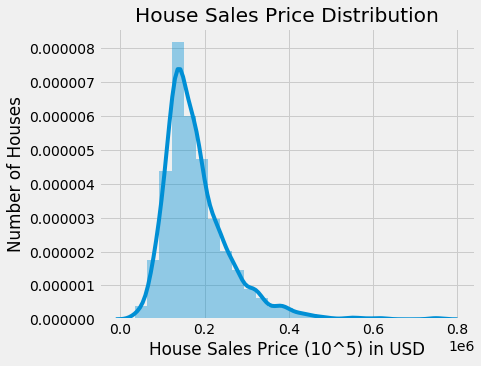

In [86]:
# "SalePrice":

# print(train['SalePrice'].describe())

# Plot graph:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6, 5))
sns.distplot(df_train.SalePrice, bins = 25)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price (10^5) in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")

# sns.distplot(df_train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

### OK.

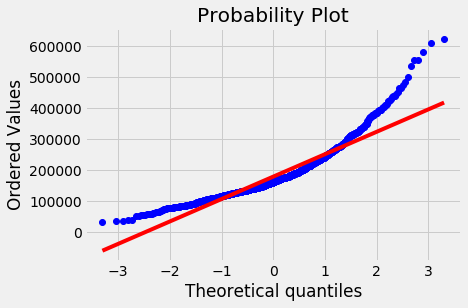

In [115]:
# "SalePrice" Probability plot:
# from scipy import stats 

res = stats.probplot(df_train['SalePrice'], plot=plt)

Skew is: 0.0674665377411
Kurtosis: 0.683932


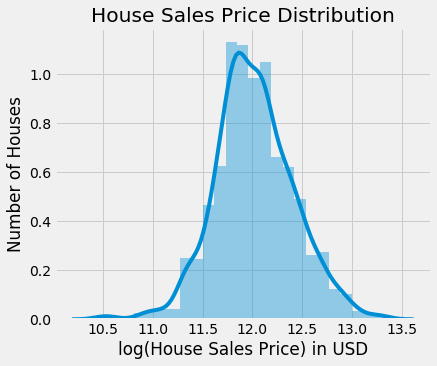

In [117]:
# "SalePrice" log to normalize it:
# https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6

plt.figure(figsize=(6,5))
sns.distplot(np.log(df_train.SalePrice), bins = 25)
plt.xlabel("log(House Sales Price) in USD")
plt.ylabel("Number of Houses")
plt.title("House Sales Price Distribution")

print("Skew is:", np.log(df_train.SalePrice).skew())
print("Kurtosis: %f" % np.log(df_train.SalePrice).kurt())

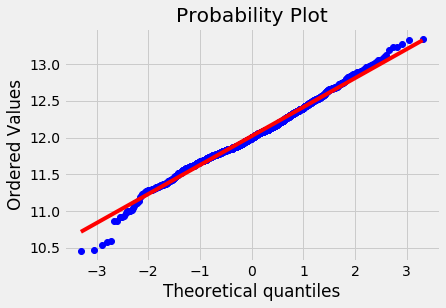

In [119]:
# "SalePrice" Probability plot with log:
# from scipy import stats 

res = stats.probplot(SalePriceLog, plot=plt)

In [87]:
# Removing outliers, according to the article:

# GrLivArea outliers: 523, 691, 1182, 1298
# LotArea outliers: 249, 313, 335, 706
# BsmtFinSF1: 1298
# TotalBsmtSF: 1298
# 1stFlrSF: 1298

deleting_outliers = df_train.drop([df_train.index[1298], df_train.index[1182],
                                   df_train.index[706], df_train.index[691], 
                                   df_train.index[523], df_train.index[335], 
                                   df_train.index[313], df_train.index[249]], 
                                  inplace=True)

deleting_outliers = df_test.drop([df_test.index[1298], df_test.index[1182],
                                   df_test.index[706], df_test.index[691], 
                                   df_test.index[523], df_test.index[335], 
                                   df_test.index[313], df_test.index[249]], 
                                  inplace=True)

df_train.loc[df_train["GrLivArea"] > 4000]
df_train.loc[df_train["LotArea"] > 100000]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,TSsnPorch,ScreenPorch,SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR_Sum,LotConfig_Inside,LandSlope_Gtl,LandSlope_ModSev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseB,Electrical_SBrkr,TotalBath,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageYrBlt_0.0,GarageYrBlt_1900.0,GarageYrBlt_1906.0,GarageYrBlt_1908.0,GarageYrBlt_1910.0,GarageYrBlt_1914.0,GarageYrBlt_1915.0,GarageYrBlt_1916.0,GarageYrBlt_1918.0,GarageYrBlt_1920.0,GarageYrBlt_1921.0,GarageYrBlt_1922.0,GarageYrBlt_1923.0,GarageYrBlt_1924.0,GarageYrBlt_1925.0,GarageYrBlt_1926.0,GarageYrBlt_1927.0,GarageYrBlt_1928.0,GarageYrBlt_1929.0,GarageYrBlt_1930.0,GarageYrBlt_1931.0,GarageYrBlt_1932.0,GarageYrBlt_1933.0,GarageYrBlt_1934.0,GarageYrBlt_1935.0,GarageYrBlt_1936.0,GarageYrBlt_1937.0,GarageYrBlt_1938.0,GarageYrBlt_1939.0,GarageYrBlt_1940.0,GarageYrBlt_1941.0,GarageYrBlt_1942.0,GarageYrBlt_1945.0,GarageYrBlt_1946.0,GarageYrBlt_1947.0,GarageYrBlt_1948.0,GarageYrBlt_1949.0,GarageYrBlt_1950.0,GarageYrBlt_1951.0,GarageYrBlt_1952.0,GarageYrBlt_1953.0,GarageYrBlt_1954.0,GarageYrBlt_1955.0,GarageYrBlt_1956.0,GarageYrBlt_1957.0,GarageYrBlt_1958.0,GarageYrBlt_1959.0,GarageYrBlt_1960.0,GarageYrBlt_19

# 3) Modeling the data:

In [ ]:
# Modeling objectives:

# Linear Regression OK
# Ridge Regression OK
# Lasso Regression OK
# Kernel Ridge Regression OK
# Random Forest Regressor
# Gradient Boosting Classifier / XGBoost

In [88]:
# Defining SalePrice for the modeling:

# Droppping SalePrice from X:
df_train_X = df_train.copy()
df_train_X.drop(columns=["SalePrice"], axis=1, inplace=True) 

# Log of SalePrice:
SalePriceLog = np.log1p(df_train.SalePrice)

In [92]:
# A list of the data:

# list(df_train)

In [93]:
# A final analysis of the data:
# # https://www.kaggle.com/mgmarques/houses-prices-complete-solution

def rstr(df_train, pred=None): 
    obs = df_train.shape[0]
    types = df_train.dtypes
    counts = df_train.apply(lambda x: x.count())
    nulls = df_train.apply(lambda x: x.isnull().sum())
    distincts = df_train.apply(lambda x: x.unique().shape[0])
    missing_ration = (df_train.isnull().sum()/ obs) * 100
    print('Data shape:', df_train.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration']
        str = pd.concat([types, counts, distincts, nulls, missing_ration], axis = 1)

    else:
        corr = df_train.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', corr_col ]
        
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

pd.set_option('display.max_rows', 360)
details = rstr(df_train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1452, 352)
___________________________
Data types:
 uint8      323
int64       25
float64      4
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,corr SalePrice
SalePrice,int64,1452,658,0,0.0,1.000000
OverallQual,int64,1452,10,0,0.0,0.802832
GrLivArea,int64,1452,855,0,0.0,0.720183
TotalBsmtSF,int64,1452,714,0,0.0,0.643992
TotalBath,float64,1452,10,0,0.0,0.634424
1stFlrSF,int64,1452,745,0,0.0,0.622602
GarageCars_3,uint8,1452,2,0,0.0,0.613607
GarageArea,float64,1452,437,0,0.0,0.601912
FullBath,int64,1452,4,0,0.0,0.558330
BsmtQual_Ex,uint8,1452,2,0,0.0,0.552030


# Multivariate Linear Regression:

In [89]:
# Multivariate Linear Regression with data treatment (Prediction results):

# Below is a list of variables with only numerical values (and not year-related):
X = df_train_X
y = SalePriceLog
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     67.81
Date:                Sun, 24 Feb 2019   Prob (F-statistic):               0.00
Time:                        11:44:08   Log-Likelihood:                 1424.0
No. Observations:                1452   AIC:                            -2238.
Df Residuals:                    1147   BIC:                            -627.4
Df Model:                         304                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage            7.498e-06      0.000      0.070      0.944      -0.000       0.000
LotArea                 3.92e-06   8.77e-07      4.470      0.000     2.2e-06    5.64e-06
OverallQual               0.0411      0.005      8.528      0.000       0.032       0.051
OverallCond               0.0418      0.004     10.403      0.000       0.034       0.050
YearBuilt                 0.0015      0.000      3.756      0.000       0.001       0.002
YearRemodAdd              0.0005      0.000      2.006      0.045    1.14e-05       0.001
MasVnrArea              2.64e-05   2.21e-05      1.195      0.232    -1.7e-05    6.98e-05
BsmtFinSF1             2.864e-05   3.67e-05      0.781      0.435   -4.33e-05       0.000
BsmtUnfSF             -2.366e-05   3.73e-05     -0.635      0.526   -9.68e-05    4.94e-05
TotalBsmtSF               0.0001   4.16e-05      2.997      0.003     4.3e-05       0.000
1stFlrSF              -3.329e-06   8.75e-05     -0.038      0.970      -0.000       0.000
2ndFlrSF               1.003e-05   8.26e-05      0.121      0.903      -0.000       0.000
GrLivArea                 0.0002   8.57e-05      2.752      0.006    6.77e-05       0.000
BsmtFullBath              0.0075      0.007      1.063      0.288      -0.006       0.021
BsmtHalfBath             -0.0029      0.013     -0.231      0.817      -0.027       0.022
FullBath                  0.0064      0.007      0.856      0.392      -0.008       0.021
HalfBath                  0.0118      0.009      1.353      0.176      -0.005       0.029
BedroomAbvGr              0.0010      0.007      0.156      0.876      -0.012       0.014
KitchenAbvGr             -0.0629      0.028     -2.222      0.027      -0.119      -0.007
TotRmsAbvGrd              0.0003      0.004      0.058      0.954      -0.008       0.009
Fireplaces                0.0067      0.012      0.544      0.587      -0.017       0.031
GarageArea             7.433e-05   3.73e-05      1.994      0.046    1.19e-06       0.000
WoodDeckSF                0.0001   2.74e-05      3.792      0.000    5.01e-05       0.000
OpenPorchSF           -1.598e-05    4.9e-05     -0.326      0.745      -0.000    8.02e-05
TSsnPorch              2.795e-05   7.87e-05      0.355      0.722      -0.000       0.000
ScreenPorch               0.0001   5.09e-05      2.224      0.026    1.33e-05       0.000
MSSubClass_20             0.0600      0.029      2.060      0.040       0.003       0.117
MSSubClass_30            -0.0254      0.033     -0.780      0.435      -0.089       0.039
MSSubClass_40             0.0210      0.066      0.320      0.749      -0.108       0.150
MSSubClass_45             0.0436      0.096      0.454      0.650      -0.145       0.232
MSSubClass_50             0.0854      0.039      2.196      0.028       0.009       0.162
MSSubClass_60          

RMSE on Training set : 29051.1351579
RMSE on Test set : 0.225973753665


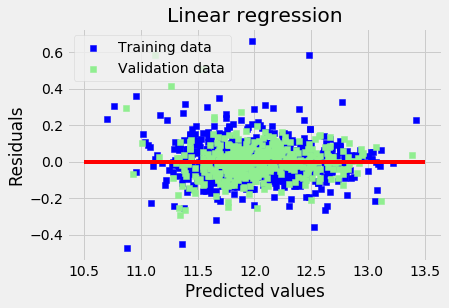

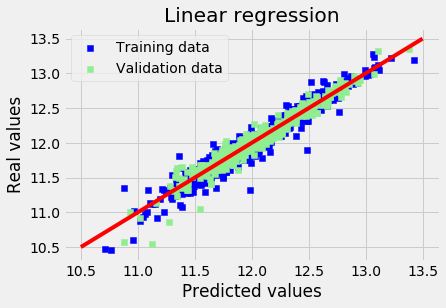

In [126]:
# Multivariate Linear Regression with data treatment (Graph):

# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error, make_scorer
# from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

# Partition the dataset in train + test sets:
X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

# Linear Regression:
lr = LinearRegression()
lr.fit(X, y)

# Look at predictions on training and validation set:
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals:
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Ridge Regression:

Ridge Regression train score: 0.938040161899
Ridge Regression test score 0.946059583545


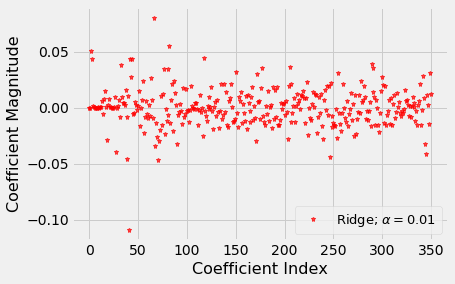

In [90]:
# Ridge Regression (Prediction results):

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Define error measure for official scoring : RMSE:
ridge = Ridge(alpha=14)
ridge.fit(X, y)

ridge_train_score = ridge.score(X_train, y_train)
ridge_test_score = ridge.score(X_test, y_test)

print ("Ridge Regression train score:", ridge_train_score)
print ("Ridge Regression test score", ridge_test_score)

plt.plot(ridge.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 30.0
Ridge RMSE on Training set : 0.115498047669
Ridge RMSE on Test set : 0.109894369361


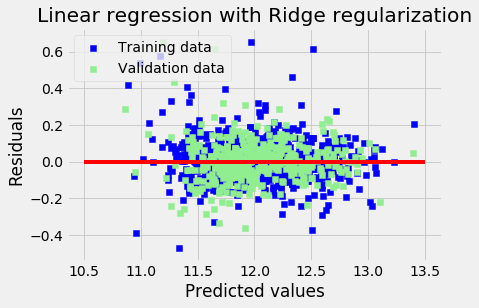

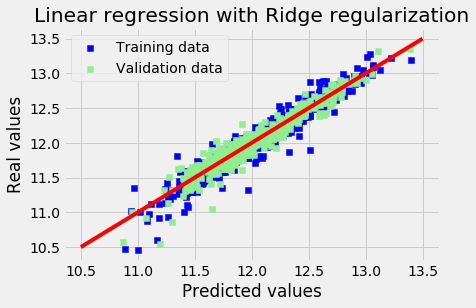

Ridge picked 345 features and eliminated the other 6 features


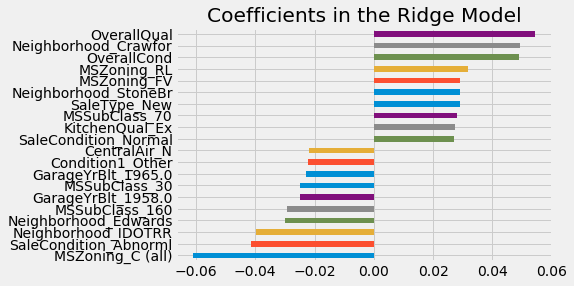

In [91]:
# Ridge Regression (Graph):
# https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60, 100])
ridge.fit(X, y)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals:
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients:
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

# Lasso Regression:

In [94]:
# Lasso Regression: Alpha tuning:

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

lasso = LassoCV(alphas = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

### Best alpha = 0.001

Best alpha : 0.001


In [95]:
# Lasso Regression: Alpha re-tuning:

lasso = LassoCV(alphas = [0.001], max_iter = 5000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

### Best alpha = 0.0008

Best alpha : 0.001
Try again for more precision with alphas centered around 0.001
Best alpha : 0.0008


Lasso Regression train score: 0.929041216094
Lasso Regression test score 0.937424615436


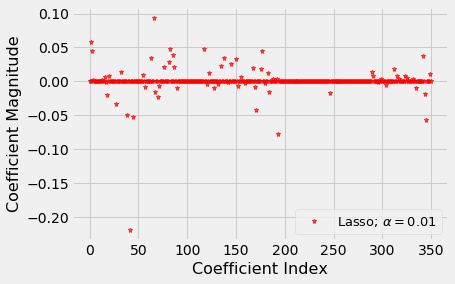

In [98]:
# Lasso Regression (Prediction results):

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

lasso = Lasso(alpha=0.0008)
lasso.fit(X, y)

lasso_train_score = lasso.score(X_train, y_train)
lasso_test_score = lasso.score(X_test, y_test)
coeff_used = np.sum(lasso.coef_!=0)

print ("Lasso Regression train score:", lasso_train_score)
print ("Lasso Regression test score", lasso_test_score)

plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

Lasso RMSE on Training set : 0.114311449956
Lasso RMSE on Test set : 0.111320413622


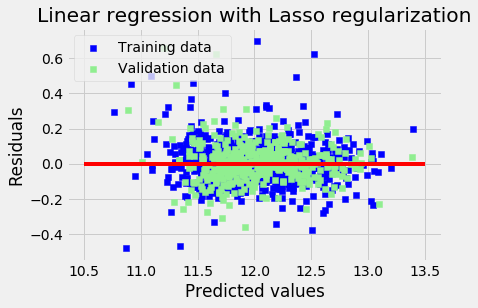

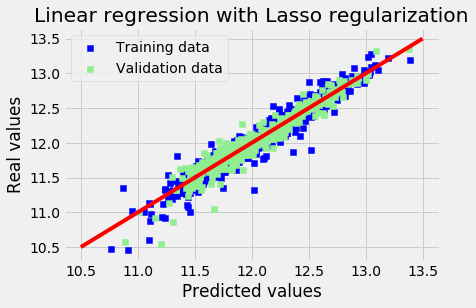

Lasso picked 98 features and eliminated the other 253 features


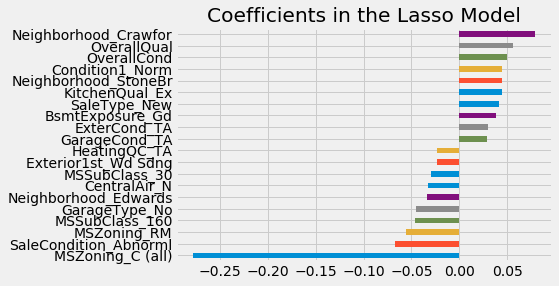

In [99]:
# Lasso Regression (Graph):

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

lasso = LassoCV(alphas = [0.0008], max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals:
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients:
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

# Kernel Ridge Regression:

Kernel Ridge RMSE on Training set : 0.12920588508
Kernel Ridge RMSE on Test set : 0.126957672128


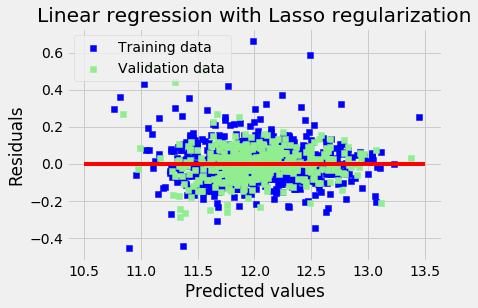

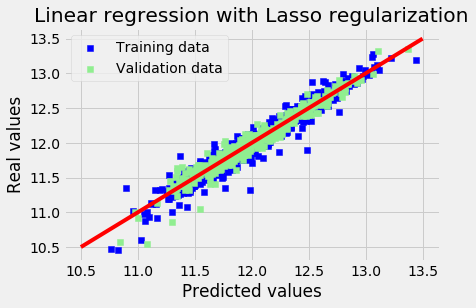

In [100]:
# Kernel Ridge Regression (Graph):
# https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

# Define error measure for official scoring : RMSE:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, 
                                   cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, 
                                   cv = 10))
    return(rmse)

kernel_ridge = KernelRidge(alpha = 1.0, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None)
kernel_ridge.fit(X, y) 

print("Kernel Ridge RMSE on Training set :", rmse_cv_train(kernel_ridge).mean())
print("Kernel Ridge RMSE on Test set :", rmse_cv_test(kernel_ridge).mean())
y_train_kr = kernel_ridge.predict(X_train)
y_test_kr = kernel_ridge.predict(X_test)

# Plot residuals:
plt.scatter(y_train_kr, y_train_kr - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_kr, y_test_kr - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions:
plt.scatter(y_train_kr, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_kr, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Random Forest Regressor:

In [105]:
# Mutual Information Regression Metric for Feature Ranking: [ERROR]
# https://www.kaggle.com/adachowicz/house-prices-random-forest-regression-analysis
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

import sklearn.feature_selection as fs # feature selection library in scikit-learn

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

yt = [i for i in SalePriceLog] # quick pre-processing of the target

mir_result = fs.mutual_info_regression(X, yt) # mutual information regression feature ordering
feature_scores = []
for i in np.arange(len(df_train_X)):
    feature_scores.append(df_train_X,mir_result)
sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))

TypeError: append() takes exactly one argument (2 given)

In [ ]:
# Mutual Information Regression (Plot): [ERROR]

fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111)
ind = np.arange(len(included_features))
plt.bar(ind,[float(i) for i in np.array(sorted_scores)[:,1]])
ax.axes.set_xticks(ind)
plt.title('Feature Importances (Mutual Information Regression)')
plt.ylabel('Importance')
# plt.xlabel('Trees in Forest')
# plt.grid()
plt.show()

In [ ]:
# Random Forest Regressor:
# https://www.kaggle.com/dougdaly/house-price-modeling-with-random-forest-regressors
    
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=352)
clf = clf.fit(X,y)
acc_decTree = clf.score(X,y)
prediction = np.exp(clf.predict(X))
print('Random Forest Score $/SF: ',round(clf.score(X,Y)*100,2))
analyze_data(result_df)

# Gradient Boosting:

In [106]:
# Gradient Boosting: Feature selection by an embedded method: [ERROR]

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

from sklearn.ensemble import GradientBoostingClassifier

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(max_depth=3, n_estimators=352, learning_rate=learning_rate, random_state=0)
    gb.fit(X, y)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

ValueError: Unknown label type: 'continuous'

In [107]:
# XGBoost: Feature selection by an embedded method: [ERROR]
# https://www.kaggle.com/mgmarques/houses-prices-complete-solution
# https://www.kaggle.com/pablocastilla/predict-house-prices-with-xgboost-regression
# https://www.kaggle.com/mathvv/prediction-on-house-prices-xgboost-tutorial
    
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

xgb = xgb.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.8, n_estimators=2000,
                             reg_alpha=0.1, reg_lambda=0.3, gamma=0.01, 
                             silent=1, random_state =7, nthread = -1)

xgb.fit(X, y)
xgb_pred = xgb.predict(X_test)
y_test = xgb.predict(X_train)

print(xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.01, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1.8, missing=None,
       n_estimators=2000, n_jobs=1, nthread=-1, objective='reg:linear',
       random_state=7, reg_alpha=0.1, reg_lambda=0.3, scale_pos_weight=1,
       seed=None, silent=1, subsample=0.5)


In [108]:
# XGBoost: Feature selection by an embedded method: [ERROR]
# https://www.youtube.com/watch?v=DuwrMrPpPMw

### https://www.kaggle.com/mathvv/prediction-on-house-prices-xgboost-tutorial

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix

X = df_train_X
y = SalePriceLog
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state=0)

xgb_regressor = XGBRegressor()
xgb_regressor.fit(X, y)

y_pred = xgb_regressor.predict(X_test, y_pred)

NameError: name 'y_pred' is not defined

In [7]:
# Searching for missing values in the data
df_train['GarageYrBlt'].isna().values.any()

# Searching for missing values in the data
df_train['GarageYrBlt'].isna().sum()

81

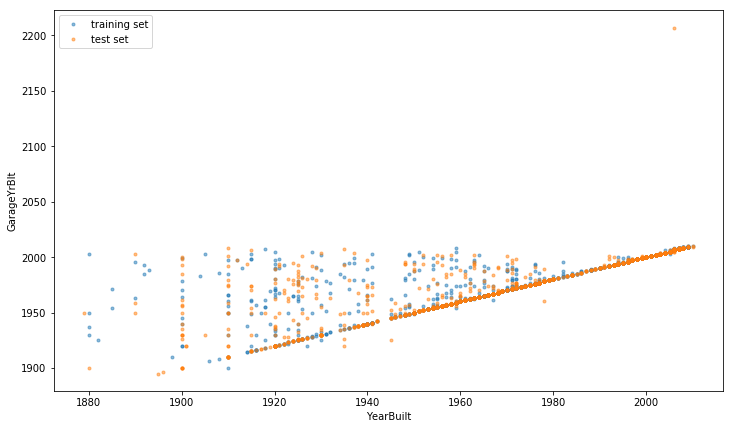

In [23]:
# Graph the correlation between two variables:
plt.figure(figsize=(12,7))
plt.xlabel("YearBuilt")
plt.ylabel("GarageYrBlt")
plt.plot(df_train.YearBuilt, df_train.GarageYrBlt,'.', alpha=0.5, label = 'training set')
plt.plot(df_test.YearBuilt, df_test.GarageYrBlt,'.', alpha=0.5, label = 'test set') 
plt.legend()

In [ ]:
# Selecting outliers from GrLivArea (table):
df_train.drop(columns=['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice']).nlargest(4, "GrLivArea")

In [ ]:
# Submitting the results:

submission = pd.DataFrame({
        "Id": df_test['Id'],
        "SalePrice": np.exp(xgb_pred)
    })
#submission.to_csv('./submission.csv', index=False)